# CHAPTER 7: SIGNAL VARIATION 2 - COMBINE DIFFERENT ASSETS

As in the previous notebook, we made some modifications to our original signal. Here, the goal is to **conditionate our analysis** by **combining data from several assets** to increase the number of observations and make the signal more robust.  

The complexity of this chapter is not in the logic of the method but in its **implementation**, so **pay close attention to each step** and **ask questions if needed**.

---

### **Important Notion**
- **Avoid introducing bias** during the conditioning process.  
- **Combine data from multiple assets** while ensuring no biases are introduced.  
- **Balance the target observations** carefully (same number of 0s and 1s) without making any mistakes.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from hurst import compute_Hc
import seaborn as sns
from FeaturesLibrary import *
from Signals import *
from FeaturesSelection import *
sns.set_style("whitegrid")

<br>

### 7.1.1. Features Engineering (Chap 2)

In [2]:
assets = ["EURUSD", "GBPUSD", "USDCAD", "USDJPY", "USDCHF"]
dfs = []

for asset in assets:
    df = pd.read_parquet(f"DATA/{asset}_4H.parquet").dropna()
    
    df = derivatives(df, "close")
    df = DC_market_regime(df, 0.015)
    df = spread(df)
    df = kama_market_regime(df, "close", 30, 100)
    for i in [1, 2, 5, 10, 20, 50]:
        df = auto_corr(df, "close", n=100, lag=i)
    for i in [1, 2, 5, 10, 20, 50]:
        df = log_transform(df, "close", i)
    df = candle_information(df)
    df = moving_yang_zhang_estimator(df, 20)
    df['linear_slope_6M'] = df["close"].rolling(125*6).apply(linear_regression_slope_market_trend)
    df['linear_slope_3M'] = df["close"].rolling(60*6).apply(linear_regression_slope_market_trend)
    df['linear_slope_1M'] = df["close"].rolling(20*6).apply(linear_regression_slope_market_trend)

    dfs.append(df)

### Target Engineering

In [ ]:
dfs_targeted = []

def dummy_labeling(df):
    df_copy = df.copy()
    
    df_copy["dummy"] = -1
    df_copy.loc[df_copy["labeling"]<0, "dummy"] = 0
    df_copy.loc[0<df_copy["labeling"], "dummy"] = 1
    
    df_copy = df_copy[df_copy["dummy"]!=-1]
    
    return df_copy

for df in dfs:
    # Create the labels (that will allow us to find the interesting features that are related to them)
    df["time"] = df.index
    df["high_time"] = df["high_time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)
    df["low_time"] = df["low_time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)
    df["time"] = df["time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)
    
    df = get_barrier(df, tp=.0050, sl=-.0025, buy=True)
    df = dummy_labeling(df)

    dfs_targeted.append(df)

### Combine the assets

In [4]:
dfs_conditionate = []
train_limit = 4000
test_size = 2000

for df in dfs_targeted:
    df = df.dropna().iloc[:train_limit+test_size]
    qtl = np.quantile(df["linear_slope_1M"].iloc[:train_limit].values,0.70)
    df = df.loc[qtl < df["linear_slope_1M"]]
    dfs_conditionate.append(df)

In [5]:
df = pd.concat(dfs_conditionate,axis=0).sort_index()
print(len(df))
df.head(10)

8185


,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,candle_way,filling,amplitude,rolling_volatility_yang_zhang,linear_slope_6M,linear_slope_3M,linear_slope_1M,time,labeling,dummy
time,,,,,,,,,,,,,,,,,,,,,
2015-05-11 20:00:00,1.11579,1.11695,1.11460,1.11542,13635,2015-05-11 20:52:00,2015-05-11 20:22:00,0.440108,4.621849,58.403361,...,-1,0.157447,0.033166,0.003746,-0.000264,-0.000052,0.000631,2015-05-11 20:00:00,11.766667,1
2015-05-11 20:00:00,1.55816,1.56126,1.55758,1.55853,18179,2015-05-11 20:38:00,2015-05-11 21:48:00,0.567581,13.025210,50.840336,...,1,0.100543,0.023743,0.003310,-0.000102,-0.000051,0.000548,2015-05-11 20:00:00,13.683333,1
2015-05-12 00:00:00,1.11549,1.11574,1.11340,1.11398,8387,2015-05-12 00:20:00,2015-05-12 03:55:00,0.606740,2.620087,5.676856,...,-1,0.645299,0.135458,0.003631,-0.000263,-0.000049,0.000624,2015-05-12 00:00:00,7.766667,1
2015-05-12 00:00:00,1.55825,1.55886,1.55633,1.55671,12180,2015-05-12 00:27:00,2015-05-12 03:56:00,0.521816,2.575107,14.163090,...,-1,0.608696,0.098878,0.003197,-0.000101,-0.000047,0.000548,2015-05-12 00:00:00,7.783333,1
2015-05-12 04:00:00,1.55671,1.55813,1.55646,1.55762,14159,2015-05-12 05:48:00,2015-05-12 04:05:00,0.470740,7.083333,42.916667,...,1,0.544910,0.058440,0.003048,-0.000100,-0.000043,0.000546,2015-05-12 04:00:00,5.683333,1
2015-05-12 04:00:00,1.11398,1.11727,1.11361,1.11711,12337,2015-05-12 07:50:00,2015-05-12 04:23:00,0.634008,20.833333,17.916667,...,1,0.855191,0.280580,0.003407,-0.000263,-0.000046,0.000616,2015-05-12 04:00:00,3.766667,1
2015-05-12 08:00:00,1.11712,1.12679,1.11668,1.12583,36868,2015-05-12 11:46:00,2015-05-12 09:01:00,0.628006,40.833333,16.250000,...,1,0.861523,0.776656,0.003422,-0.000262,-0.000043,0.000610,2015-05-12 08:00:00,-3.683333,0
2015-05-12 08:00:00,1.55762,1.56476,1.55566,1.56341,36343,2015-05-12 11:47:00,2015-05-12 11:00:00,0.516180,34.166667,52.083333,...,1,0.636264,0.371031,0.003101,-0.000099,-0.000039,0.000545,2015-05-12 08:00:00,23.533333,1
2015-05-12 12:00:00,1.56340,1.57101,1.56326,1.56503,42321,2015-05-12 13:41:00,2015-05-12 12:00:00,0.558415,0.416667,12.500000,...,1,0.210323,0.104206,0.003239,-0.000099,-0.000035,0.000548,2015-05-12 12:00:00,19.533333,1


In [6]:
# Separate rows based on the value of 'dummy'
dummy_0 = df[df['dummy'] == 0]
dummy_1 = df[df['dummy'] == 1]

# Find the minimum size between the two groups
min_size = min(len(dummy_0), len(dummy_1))

# Randomly sample without replacement to obtain balanced groups
dummy_0_sample = dummy_0.sample(n=min_size, random_state=42)
dummy_1_sample = dummy_1.sample(n=min_size, random_state=42)

# Combine the samples to create a balanced DataFrame
balanced_df = pd.concat([dummy_0_sample, dummy_1_sample])

# Shuffle the rows to avoid any bias
balanced_df = balanced_df.sort_index()

# Display the balanced DataFrame
print(balanced_df)

                        open     high      low    close  tick_volume  \
time                                                                   
2015-05-11 20:00:00  1.11579  1.11695  1.11460  1.11542        13635   
2015-05-11 20:00:00  1.55816  1.56126  1.55758  1.55853        18179   
2015-05-12 00:00:00  1.55825  1.55886  1.55633  1.55671        12180   
2015-05-12 00:00:00  1.11549  1.11574  1.11340  1.11398         8387   
2015-05-12 04:00:00  1.11398  1.11727  1.11361  1.11711        12337   
...                      ...      ...      ...      ...          ...   
2019-03-19 12:00:00  1.33184  1.33219  1.32500  1.32633        17549   
2019-03-19 16:00:00  1.32632  1.33180  1.32551  1.33072        18928   
2019-03-19 20:00:00  1.33072  1.33277  1.33055  1.33213         8811   
2019-03-20 12:00:00  1.33304  1.33415  1.33150  1.33340        10887   
2019-03-20 16:00:00  1.33338  1.33469  1.33107  1.33190        17669   

                               high_time             low_time  

<br>

### 7.1.4 Features Selection (Chap 4)

In [7]:
list_X = ['hurst', '0_to_20', '20_to_40', '40_to_60', '60_to_80', '80_to_100',
    'velocity', 'acceleration',
       'market_regime', 'spread', 'kama_diff',
       'kama_trend', 'autocorr_1', 'autocorr_2', 'autocorr_5',
       'autocorr_10', 'autocorr_20', 'autocorr_50', 'ret_log_1',
       'ret_log_2', 'ret_log_5', 'ret_log_10', 'ret_log_20', 'ret_log_50',
       'candle_way', 'filling', 'amplitude', 'rolling_volatility_yang_zhang',
         'linear_slope_6M', 'linear_slope_3M']
col_y = "dummy"

# Remove the Nan values
df_clean = df[list_X + [col_y]].dropna()
split = 3 * len(df_clean)//4
date_split = df_clean.index[split]

# Split our data into features and target
X_train = balanced_df.loc[:date_split,:][list_X]
y_train = balanced_df.loc[:date_split,:][col_y]

# Standardize the data before selecting the features 
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

# Keep a train set with the features name (essential for the selection)
X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train.columns, index=X_train.index)

In [8]:
vif_results_clean = remove_intercolinarity(X_train_sc_df)
vif_results_clean.index

Index(['hurst', '0_to_20', '40_to_60', '60_to_80', '80_to_100', 'velocity',
       'acceleration', 'market_regime', 'spread', 'kama_diff', 'kama_trend',
       'autocorr_1', 'autocorr_10', 'autocorr_20', 'autocorr_50', 'ret_log_1',
       'ret_log_2', 'ret_log_5', 'ret_log_10', 'ret_log_20', 'ret_log_50',
       'candle_way', 'filling', 'amplitude', 'rolling_volatility_yang_zhang',
       'linear_slope_6M', 'linear_slope_3M'],
      dtype='object', name='Feature')

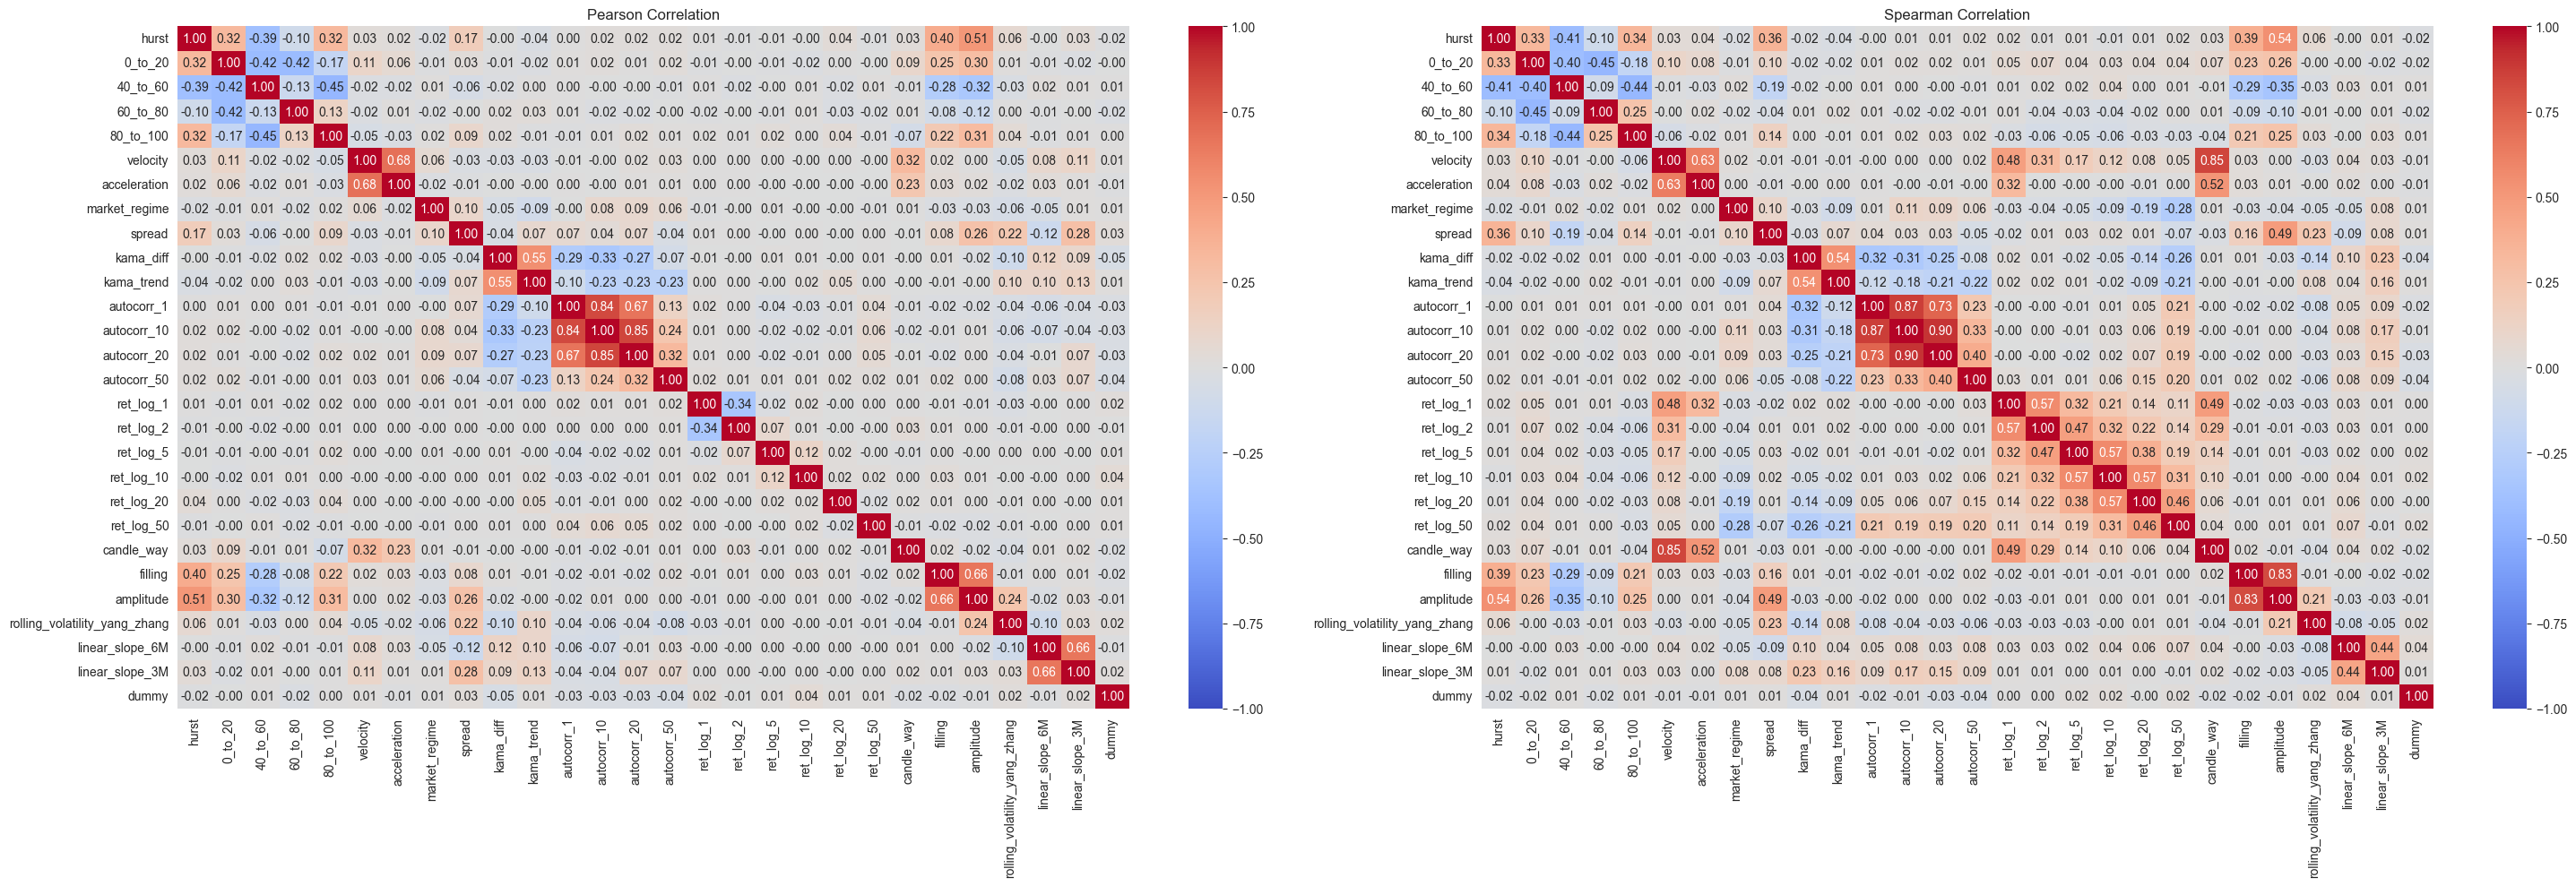

In [9]:
df_train = pd.concat((X_train_sc_df[vif_results_clean.index], y_train), axis=1)
correlation_graphs(df_train)

In [10]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

# For a dummy variable (classification)
mi_scores = mutual_info_classif(X_train_sc_df, y_train)
mi_df = pd.DataFrame({'Feature': X_train_sc_df.columns, 'Mutual Information': mi_scores}).sort_values(by='Mutual Information', ascending=False)
mi_df = mi_df.set_index("Feature")


# Summarize the info
linear_correlation_target = df_train.corr()["dummy"]*100
linear_correlation_target.name = "lr_dummy"

nonlinear_correlation_target = df_train.corr(method="spearman")["dummy"]*100
nonlinear_correlation_target.name = "nlr_dummy"
df_mi_vif = pd.concat((vif_results_clean, mi_df, linear_correlation_target, nonlinear_correlation_target), axis=1).dropna()
df_mi_vif.sort_values("Mutual Information", ascending=False).dropna()

,VIF,Mutual Information,lr_dummy,nlr_dummy
linear_slope_6M,2.19,0.105964,-0.958601,3.993577
linear_slope_3M,2.43,0.059477,1.814352,1.072363
autocorr_1,3.65,0.021917,-2.855428,-1.959474
autocorr_20,4.02,0.016412,-3.181938,-3.335945
autocorr_10,7.18,0.014214,-3.414554,-1.403477
rolling_volatility_yang_zhang,1.23,0.014027,2.317461,2.095587
60_to_80,1.49,0.013821,-2.418493,-1.903891
ret_log_5,1.02,0.006715,1.067238,1.677181
ret_log_1,1.13,0.004783,2.224470,0.495831
acceleration,1.91,0.003956,-1.499694,-0.812063


In [11]:
df_filtered = df_mi_vif[
    (df_mi_vif['Mutual Information'] > 0.01) |
    (df_mi_vif['lr_dummy'].abs() > 10) |
    (df_mi_vif['nlr_dummy'].abs() > 10)
]

# Afficher le résultat
df_filtered

,VIF,Mutual Information,lr_dummy,nlr_dummy
60_to_80,1.49,0.013821,-2.418493,-1.903891
autocorr_1,3.65,0.021917,-2.855428,-1.959474
autocorr_10,7.18,0.014214,-3.414554,-1.403477
autocorr_20,4.02,0.016412,-3.181938,-3.335945
rolling_volatility_yang_zhang,1.23,0.014027,2.317461,2.095587
linear_slope_6M,2.19,0.105964,-0.958601,3.993577
linear_slope_3M,2.43,0.059477,1.814352,1.072363


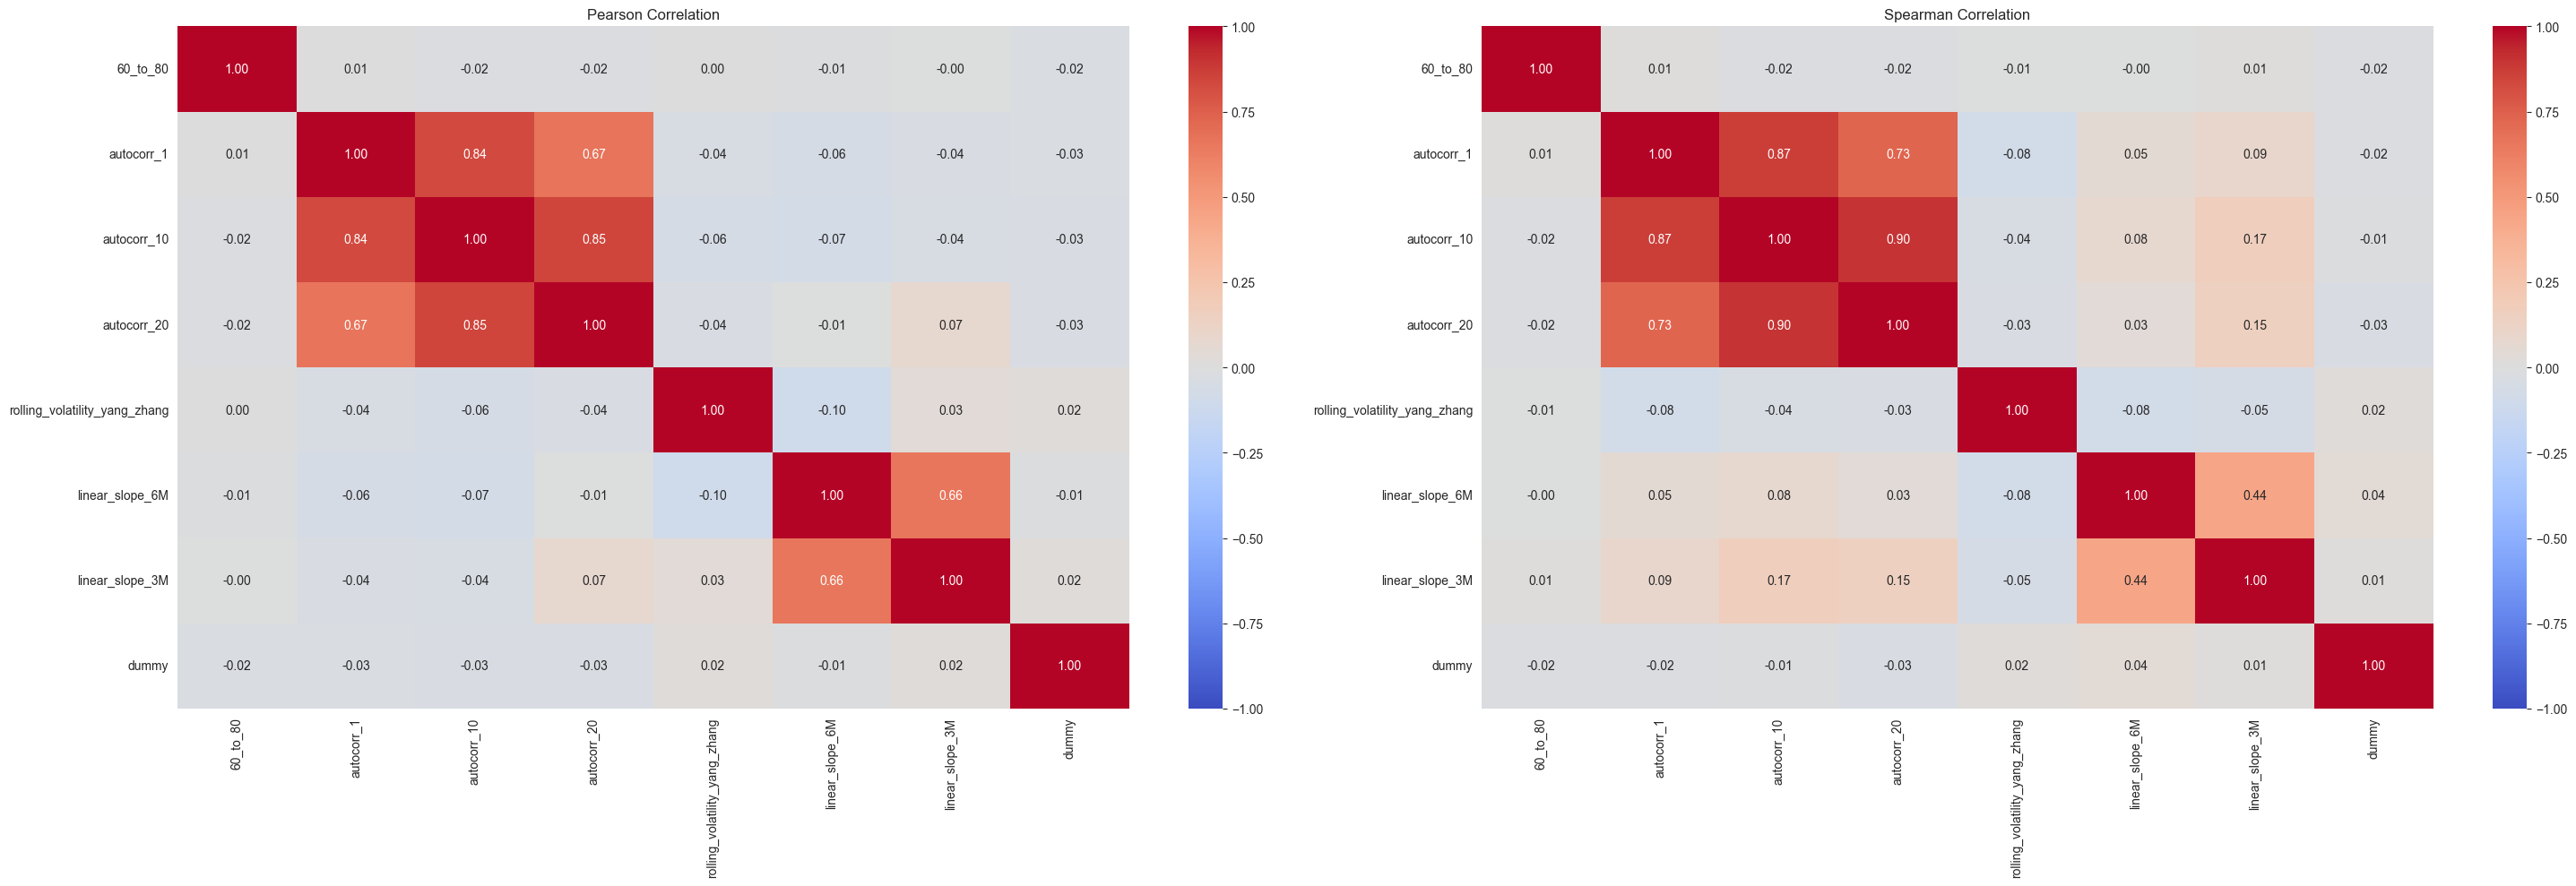

In [12]:
df_train_bis = pd.concat((X_train_sc_df[df_filtered.index], y_train), axis=1)
correlation_graphs(df_train_bis)

In [13]:
df_filtered.index

Index(['60_to_80', 'autocorr_1', 'autocorr_10', 'autocorr_20',
       'rolling_volatility_yang_zhang', 'linear_slope_6M', 'linear_slope_3M'],
      dtype='object')

- First of all, we see a correlation higher than 60% with `velocity`and `acceleration`& `ret_log_1`, so I remove `velocity`.
- We see very high correlations in the auto correlation square. To remove the highest level of ocrrelation removing the less variables possible, we remove `auto_corr_1` & `auto_corr_20`.
- Same problem in the log return square. We remove `ret_log_2`& `ret_log_10`.

<br>

### 7.1.5 MODELS (Chap 5)

In [14]:
list_X = ['hurst', 'kama_diff', 'autocorr_10','autocorr_50', 'ret_log_2', 'ret_log_5', 'ret_log_10',
    'filling', 'rolling_volatility_yang_zhang',
       'linear_slope_6M', 'linear_slope_3M']
col_y = "dummy"

# Remove the Nan values
df_clean = df[list_X + [col_y]].dropna()
split = 3 * len(df_clean)//4
date_split = df_clean.index[split]

# Split our data into features and target
X_train = balanced_df.loc[:date_split,:][list_X]
y_train = balanced_df.loc[:date_split,:][col_y]

X_test = df_clean.loc[date_split:,:][list_X]
y_test = df_clean.loc[date_split:,:][col_y]

# Standardize the data before selecting the features 
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test) # WE DO NOT FIT THE MODEL ON THE TEST DATA ONLY ON THE TRAIN DATA

# Keep a train set with the features name (essential for the selection)
X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train.columns, index=X_train.index)
X_test_sc_df = pd.DataFrame(X_test_sc, columns=X_test.columns, index=X_test.index)

In [15]:
from sklearn.metrics import confusion_matrix


def model_output_overview(model_class, X_train_sc=X_train_sc, X_test_sc=X_test_sc, y_train=y_train, y_test=y_test):
    model = model_class.fit(X_train_sc, y_train.values)
    y_pred = model.predict(X_test_sc)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    precision_class_0 = 100 * conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    precision_class_1 = 100 * conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])

    print(f"Precision Class 0: {precision_class_0:.2f} % \t Precision Class 1: {precision_class_1:.2f} %")

    print(f"NB Prediction Class 0: {(conf_matrix[0][0] + conf_matrix[1][0])} \t NB Prediction Class 1: {(conf_matrix[1][1] + conf_matrix[0][1])}")

In [16]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression, LinearRegression
model_output_overview(LogisticRegression())

Precision Class 0: 60.11 % 	 Precision Class 1: 39.53 %
NB Prediction Class 0: 1622 	 NB Prediction Class 1: 425


In [17]:
# LINEAR SVC
from sklearn.svm import LinearSVC, LinearSVR
model_output_overview(LinearSVC(max_iter=10_000))

Precision Class 0: 60.14 % 	 Precision Class 1: 39.62 %
NB Prediction Class 0: 1623 	 NB Prediction Class 1: 424


/Users/lucasinglese/opt/anaconda3/envs/TradingAlgo/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [18]:
# NON LINEAR SVC
from sklearn.svm import SVC, SVR
model_output_overview(SVC(C=3))

Precision Class 0: 59.27 % 	 Precision Class 1: 38.26 %
NB Prediction Class 0: 1289 	 NB Prediction Class 1: 758


In [19]:
# STANDARD RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
model_output_overview(RandomForestClassifier(n_estimators=100, max_depth=6, random_state=56))

Precision Class 0: 58.46 % 	 Precision Class 1: 35.46 %
NB Prediction Class 0: 1466 	 NB Prediction Class 1: 581


In [20]:
# Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
model_class = ExtraTreesClassifier(n_estimators=100, max_depth=6, min_samples_split=2, random_state=56)
model_output_overview(model_class)

Precision Class 0: 59.92 % 	 Precision Class 1: 34.91 %
NB Prediction Class 0: 1941 	 NB Prediction Class 1: 106


In [21]:
from sklearn.ensemble import BaggingClassifier
model_output_overview(BaggingClassifier(estimator=SVC(C=3),
                        n_estimators=10, random_state=56))

Precision Class 0: 60.90 % 	 Precision Class 1: 40.97 %
NB Prediction Class 0: 1261 	 NB Prediction Class 1: 786


In [22]:
from sklearn.neural_network import MLPClassifier
model_class = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), random_state=56)
model_output_overview(model_class)

Precision Class 0: 61.45 % 	 Precision Class 1: 41.33 %
NB Prediction Class 0: 1118 	 NB Prediction Class 1: 929


/Users/lucasinglese/opt/anaconda3/envs/TradingAlgo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
from sklearn.ensemble import VotingClassifier, VotingRegressor

model_class = VotingClassifier(
    estimators=[('lr', LogisticRegression()),
                ('linsvc', LinearSVC(max_iter=10_000)),
                ('svc', SVC(C=3)),
                ('rfc', RandomForestClassifier(n_estimators=1_000, max_depth=None, random_state=56)),
               ('mlp', MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), random_state=56)),
               ('bagsvc',BaggingClassifier(estimator=SVC(C=3),n_estimators=10, random_state=56))], voting='hard')

model_output_overview(model_class)

/Users/lucasinglese/opt/anaconda3/envs/TradingAlgo/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lucasinglese/opt/anaconda3/envs/TradingAlgo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Precision Class 0: 60.84 % 	 Precision Class 1: 42.13 %
NB Prediction Class 0: 1596 	 NB Prediction Class 1: 451


In [1]:
precision = 42.17
number_of_trades = 451
(0.0048*precision - 0.0027*(100-precision)) * number_of_trades # In 1 year

20.87002499999999

------

**My Observations**
- Using the **Linear Slope 1M** improves the conditioning significantly. If you use volatility as before without making any modifications here, it is not profitable. This is a **positive first result** (I haven’t tested others yet).  
- We frequently encounter problems with **convergence**. It is essential to identify **more features**, and more **precisely targeted features** to address this issue.  
- While we can't use cross-validation with a good balance between target classes, the fact that we incorporate **several assets** significantly improves robustness (similar to performing cross-validation across multiple assets).  